In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Set Pandas to display numbers without scientific notation
pd.set_option('display.float_format', '{:.3f}'.format)

# Step 1: Load and Merge All Files
cleaned_data_folder = 'pdata'  #1 Cleaned data
normalized_data_folder = 'ldata' #2 Normalized data

all_clean_files = [f for f in os.listdir(cleaned_data_folder) if f.endswith('.csv')]


In [2]:
import numpy as np
from scipy.optimize import curve_fit

# Example drying function (exponential decay model)
def drying_curve(time, a, b, c):
    return a * np.exp(-b * time) + c

i=0

for file in all_clean_files:
    print(f"\rProcessing file {i}", end='', flush=True)
    i=i+1
    df = pd.read_csv(os.path.join(cleaned_data_folder, file))
    
    data=df
    #display(data)

    # Get the value from row 0, column 1 (which is 'Unix_time_Stamp' column, index 2)
    value_to_subtract = data.iloc[0, 1]

    #print(f"Value to subtract: {value_to_subtract}")

    # Subtract this value from the entire 'Unix_time_Stamp' column
    data['Unix_time_Stamp'] = (data['Unix_time_Stamp'] - value_to_subtract)/1800
    
    # Rename the last column to 'Weight'
    #print(data.columns.values[-1])# = 'Weight'

    # Get the name of the last column
    last_column_name = data.columns[-1]

    # Rename the last column to 'Weight'
    data = data.rename(columns={last_column_name: 'Weight'})

    # Get the value from row 0, column 5 (which is 'Weight' column, index 2)
    value_to_normalize = data.iloc[0, 5]

    #print(f"Value to value_to_normalize: {value_to_normalize}")

    # Subtract this value from the entire 'Unix_time_Stamp' column
    data['Weight'] = (data['Weight'])/value_to_normalize

    # Drop the 3rd column by name
    data = data.drop('Date', axis=1)

    # Rename 'Unix_time_Stamp' to 'time'
    data = data.rename(columns={'Unix_time_Stamp': 'Time'})
    
    # Convert the "Time" column from float to integer
    data['Time'] = data['Time'].astype(int)

    # Calculate the average Temp and Humidity
    avg_temp = data['Temp'].mean()
    avg_temp = round(avg_temp, 1)
    avg_humidity = data['Humidity'].mean()
    avg_humidity = round(avg_humidity, 1)

    trim_value = 1600
    time = np.arange(len(data))  # Create a time array of the same length
    time_ext = np.arange(trim_value)
    
    popt1, pcov = curve_fit(drying_curve, time, data['Weight'])#mean_std_weights)
    a, b, c = popt1

    # Generate fitted values using the model
    fitted_weights_dev1_ext = drying_curve(time_ext, a, b, c)

    # Ensure the DataFrame is at least 'trim_value' long, and truncate if necessary
    if len(data) > trim_value:
        data = data.iloc[:trim_value]

    # Pad the DataFrame with NaN values if it's shorter than trim_value
    if len(data) < trim_value:
        # Calculate how many rows we need to add
        rows_to_add = trim_value - len(data)
        
        # Get the last value of Time
        last_time = data['Time'].iloc[-1]
        
        # Create new rows with padded values
        padding = pd.DataFrame({
            'Jerky_ID': [data['Jerky_ID'].iloc[0]] * rows_to_add,  # Assuming Jerky_ID remains constant
            'Time': np.arange(last_time + 1, last_time + 1 + rows_to_add),  # Continue Time from the last value
            'Temp': [avg_temp] * rows_to_add,  # Use average Temp
            'Humidity': [avg_humidity] * rows_to_add,  # Use average Humidity
            'Weight': [np.nan] * rows_to_add,  # Leave Weight as NaN
            'Alg_Weight': fitted_weights_dev1_ext[len(data):]  # Fill in the remaining fitted weights
        })

        # Append the padded rows to the original DataFrame
        data = pd.concat([data, padding], ignore_index=True)

    # Add 'alg_weight' column from fitted values
    data['Alg_Weight'] = fitted_weights_dev1_ext

    #print(f"\n{file}")

    # Construct the new filename by splitting the original and appending '_norm'
    base_name, ext = os.path.splitext(file)  # Split into name and extension
    new_filename = f"{base_name}_norm{ext}"  # Append '_norm' to the base name

    # Create the full path for saving
    full_path = os.path.join(normalized_data_folder, new_filename)

    # Write the DataFrame to the new CSV file
    data.to_csv(full_path, index=False)  # index=False to avoid writing row indices

    #print(f"DataFrame written to {full_path}")
    #display(data)

    
    
    if i>100:
        break
    #


Processing file 20

C:\Users\Neil\AppData\Local\Temp\ipykernel_23480\918270952.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * time) + c
C:\Users\Neil\AppData\Local\Temp\ipykernel_23480\918270952.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * time) + c
C:\Users\Neil\AppData\Local\Temp\ipykernel_23480\918270952.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * time) + c
C:\Users\Neil\AppData\Local\Temp\ipykernel_23480\918270952.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * time) + c
C:\Users\Neil\AppData\Local\Temp\ipykernel_23480\918270952.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * time) + c
C:\Users\Neil\AppData\Local\Temp\ipykernel_23480\918270952.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * time) + c
C:\Users\Neil\AppData\Local\Temp\ipykernel_23480\918270952.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * ti

Processing file 36

C:\Users\Neil\AppData\Local\Temp\ipykernel_23480\918270952.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * time) + c
C:\Users\Neil\AppData\Local\Temp\ipykernel_23480\918270952.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * time) + c
C:\Users\Neil\AppData\Local\Temp\ipykernel_23480\918270952.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * time) + c


Processing file 63

C:\Users\Neil\AppData\Local\Temp\ipykernel_23480\918270952.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * time) + c
C:\Users\Neil\AppData\Local\Temp\ipykernel_23480\918270952.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * time) + c
C:\Users\Neil\AppData\Local\Temp\ipykernel_23480\918270952.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * time) + c
C:\Users\Neil\AppData\Local\Temp\ipykernel_23480\918270952.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * time) + c
C:\Users\Neil\AppData\Local\Temp\ipykernel_23480\918270952.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * time) + c
C:\Users\Neil\AppData\Local\Temp\ipykernel_23480\918270952.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * time) + c
C:\Users\Neil\AppData\Local\Temp\ipykernel_23480\918270952.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * ti

Processing file 71

C:\Users\Neil\AppData\Local\Temp\ipykernel_23480\918270952.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * time) + c
C:\Users\Neil\AppData\Local\Temp\ipykernel_23480\918270952.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * time) + c


In [3]:

all_normalized_files = [f for f in os.listdir(normalized_data_folder) if f.endswith('.csv')]

del data

dfs = []
for file in all_normalized_files:
    df = pd.read_csv(os.path.join(normalized_data_folder, file))
    dfs.append(df)
    
# Merge all the dataframes into one
data = pd.concat(dfs, ignore_index=True)

# Convert data types if necessary
data['Time'] = data['Time'].astype(float)
data['Temp'] = data['Temp'].astype(float)
data['Humidity'] = data['Humidity'].astype(float)
data['Weight'] = data['Weight'].astype(float)
data['Alg_Weight'] = data['Alg_Weight'].astype(float)

# Display the modified DataFrame
display(data)
#display(data)

,Jerky_ID,Time,Temp,Humidity,Weight,Alg_Weight
0,"0,1",0.000,22.100,30.700,1.000,1.000
1,"0,1",1.000,22.100,29.100,0.996,0.997
2,"0,1",2.000,21.100,29.600,0.993,0.994
3,"0,1",3.000,20.600,29.800,0.990,0.991
4,"0,1",4.000,20.200,30.500,0.987,0.988
...,...,...,...,...,...,...
115195,"9,5",1595.000,19.300,28.100,NaN,0.557
115196,"9,5",1596.000,19.300,28.100,NaN,0.557
115197,"9,5",1597.000,19.300,28.100,NaN,0.557
115198,"9,5",1598.000,19.300,28.100,NaN,0.557


In [4]:
# Create features based on the current time
def create_features(df):
    df['Weight_Lag_1'] = df['Alg_Weight'].shift(1)  # Previous weight
    df['Weight_Lag_2'] = df['Alg_Weight'].shift(2)  
    df['Weight_Lag_3'] = df['Alg_Weight'].shift(3)  
    # df['Weight_Lag_4'] = df['Alg_Weight'].shift(4)  
    # df['Weight_Lag_5'] = df['Alg_Weight'].shift(5)  
    # df['Weight_Lag_6'] = df['Alg_Weight'].shift(6)  
    # df['Weight_Lag_7'] = df['Alg_Weight'].shift(7) 
    # df['Weight_Lag_8'] = df['Alg_Weight'].shift(8) 
    # df['Weight_Lag_9'] = df['Alg_Weight'].shift(9) 
    # df['Weight_Lag_10'] = df['Alg_Weight'].shift(10) 
    # You can add more lag features if necessary
    return df

data = create_features(data)
data.dropna(inplace=True)  # Drop rows with NaN values

#print(data.head(20))
display(data)


,Jerky_ID,Time,Temp,Humidity,Weight,Alg_Weight,Weight_Lag_1,Weight_Lag_2,Weight_Lag_3
3,"0,1",3.000,20.600,29.800,0.990,0.991,0.994,0.997,1.000
4,"0,1",4.000,20.200,30.500,0.987,0.988,0.991,0.994,0.997
5,"0,1",5.000,20.400,30.100,0.984,0.985,0.988,0.991,0.994
6,"0,1",6.000,20.100,30.300,0.980,0.982,0.985,0.988,0.991
7,"0,1",7.000,20.200,30.100,0.978,0.979,0.982,0.985,0.988
...,...,...,...,...,...,...,...,...,...
113784,"9,5",184.000,18.600,26.600,0.637,0.638,0.639,0.640,0.641
113785,"9,5",185.000,18.600,26.600,0.637,0.638,0.638,0.639,0.640
113786,"9,5",186.000,18.700,26.600,0.637,0.637,0.638,0.638,0.639
113787,"9,5",187.000,18.800,26.900,0.637,0.636,0.637,0.638,0.638


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Define your features and target variable
features = data[['Time', 'Temp', 'Humidity', 'Weight_Lag_1', 'Weight_Lag_2', 'Weight_Lag_3']]#, 'Weight_Lag_4', 'Weight_Lag_5','Weight_Lag_6','Weight_Lag_7','Weight_Lag_8','Weight_Lag_9','Weight_Lag_10']]
target = data['Alg_Weight']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
#model = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 1.4129790183914926e-05


Future Time: 8.3 days, Predicted Weight: 499.920233


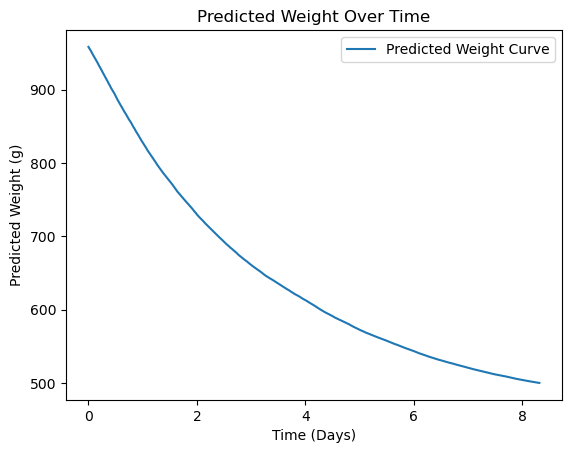

In [28]:
def predict_future_weight(time, temp, humidity, previous_weight_1,previous_weight_2,previous_weight_3):#,previous_weight_4,previous_weight_5,previous_weight_6,previous_weight_7,previous_weight_8,previous_weight_9,previous_weight_10):
    # Create a DataFrame for the input
    input_data = pd.DataFrame({
        'Time': [time],
        'Temp': [temp],
        'Humidity': [humidity],
        'Weight_Lag_1': [previous_weight_1],
        'Weight_Lag_2': [previous_weight_2],
        'Weight_Lag_3': [previous_weight_3]#,
        # 'Weight_Lag_4': [previous_weight_4],
        # 'Weight_Lag_5': [previous_weight_5],
        # 'Weight_Lag_6': [previous_weight_6],
        # 'Weight_Lag_7': [previous_weight_7],
        # 'Weight_Lag_8': [previous_weight_8],
        # 'Weight_Lag_9': [previous_weight_9],
        # 'Weight_Lag_10': [previous_weight_10]
            # You might want to adjust this
    })
    
    # # Convert the 'Weight_Lag' columns to numeric, coercing errors to NaN
    # for col in ['Weight_Lag_1', 'Weight_Lag_2', 'Weight_Lag_3', 'Weight_Lag_4', 'Weight_Lag_5', 
    #             'Weight_Lag_6', 'Weight_Lag_7', 'Weight_Lag_8', 'Weight_Lag_9', 'Weight_Lag_10']:
    #     input_data[col] = pd.to_numeric(input_data[col], errors='coerce')

    return model.predict(input_data)

# # Example usage
# future_time = 1  # Future time in seconds
# predicted_weight = predict_future_weight(future_time, 18.2, 40.3, 1)
# print(f'Predicted Weight at time 0: {predicted_weight[0]*1000}')

import matplotlib.pyplot as plt

# Lists to store time and predicted weight
time_list = []
weight_list = []

# previous_weight_10=1.0
# previous_weight_9=0.994413407821229
# previous_weight_8=0.9832402234636871
# previous_weight_7=0.9776536312849162
# previous_weight_6=0.9720670391061452
# previous_weight_5=0.9664804469273743
# previous_weight_4=0.9664804469273743
previous_weight_3=0.9664804469273743
previous_weight_2=0.9608938547486033
previous_weight_1=0.9608938547486033

# previous_weight_10=1
# previous_weight_9=0.996
# previous_weight_8=0.993
# previous_weight_7=0.990
# previous_weight_6=0.987
# previous_weight_5=0.984
# previous_weight_4=0.980
# previous_weight_3=0.978
# previous_weight_2=0.974
# previous_weight_1=0.972

predicted_weight=1
# Loop through future time values from x to xx
for future_time in range(0, 600):  # This will iterate from 20 to 100 inclusive
    predicted_weight = predict_future_weight(future_time, 20, 20 ,previous_weight_1,previous_weight_2,previous_weight_3)#,previous_weight_4,previous_weight_5,previous_weight_6,previous_weight_7,previous_weight_8,previous_weight_9,previous_weight_10)

    # previous_weight_10=previous_weight_9
    # previous_weight_9=previous_weight_8
    # previous_weight_8=previous_weight_7
    # previous_weight_7=previous_weight_6
    # previous_weight_6=previous_weight_5
    # previous_weight_5=previous_weight_4
    # previous_weight_4=previous_weight_3
    previous_weight_3=previous_weight_2
    previous_weight_2=previous_weight_1
    previous_weight_1=predicted_weight

    # Store the time and weight for plotting
    time_list.append(future_time)
    weight_list.append(predicted_weight[0])  # Assuming predict_future_weight returns an array


    if predicted_weight<0.5:
        print(f'Future Time: {future_time/48:.1f} days, Predicted Weight: {predicted_weight[0] * 1000:.6f}')

        break
    elif future_time == 599:
        print(f'Did not cure Future Time: {future_time/48:.1f} days, Predicted Weight: {predicted_weight[0] * 1000:.6f}')

# Plot the curve
plt.plot([t / 48 for t in time_list], [w * 1000 for w in weight_list], label='Predicted Weight Curve')

# Adding labels and title
plt.xlabel('Time (Days)')
plt.ylabel('Predicted Weight (g)')
plt.title('Predicted Weight Over Time')
plt.legend()

# Show the plot
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Example function for exponential decay
def exponential_decay(t, a, b, c):
    return a * np.exp(-b * t) + c

# Example data (replace with your data)
time = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  # Example time points
weight = np.array([1.0, 0.85, 0.72, 0.61, 0.52, 0.44, 0.38, 0.33, 0.29, 0.26, 0.23])  # Example weights

# Fit the exponential decay function to the data
params, covariance = curve_fit(exponential_decay, time, weight, p0=(1, 0.1, 0.5))

# Extract the fitted parameters
a, b, c = params

# Generate fitted weights for plotting
fitted_weights = exponential_decay(time, a, b, c)

# Plot the data and the fitted curve
plt.scatter(time, weight, label='Data', color='red')
plt.plot(time, fitted_weights, label=f'Fitted Curve: a={a:.3f}, b={b:.3f}, c={c:.3f}', color='blue')
plt.xlabel('Time')
plt.ylabel('Weight')
plt.title('Exponential Decay Fit')
plt.legend()
plt.show()
